# Integrating data using ingest (Scanpy tutorial) × ScGeo geometry

This notebook follows the **original Scanpy "integrating data using ingest"** flow and adds **ScGeo** panels to quantify:

- Δ shift between reference vs query
- overlap (Bhattacharyya / Hellinger)
- global distribution distance + permutation p-value
- composition statistics per cluster/node

ScGeo uses **`batch`** (ref vs new) as the `condition_key`.

In [1]:
import numpy as np
import scanpy as sc
import scgeo as sg

# Integrating data using ingest and BBKNN

The following tutorial describes a simple PCA-based method for integrating data we call {func}`~scanpy.tl.ingest` and compares it with [BBKNN](https://github.com/Teichlab/bbknn) {cite:p}`Polanski2019`.
BBKNN integrates well with the Scanpy workflow and is accessible through the {func}`~scanpy.external.pp.bbknn` function.
    
The {func}`~scanpy.tl.ingest` function assumes an annotated reference dataset that captures the biological variability of interest.
The rational is to fit a model on the reference data and use it to project new data.
For the time being, this model is a PCA combined with a neighbor lookup search tree, for which we use UMAP's implementation {cite:p}`McInnes2018`.
Similar PCA-based integrations have been used before, for instance, in {cite:t}`Weinreb2020`.

* As {func}`~scanpy.tl.ingest` is simple and the procedure clear, the workflow is transparent and fast.
* Like BBKNN, {func}`~scanpy.tl.ingest` leaves the data matrix itself invariant.
* Unlike BBKNN, {func}`~scanpy.tl.ingest` solves the label mapping problem (like scmap) and maintains an embedding that might have desired properties like specific clusters or trajectories.

We refer to this *asymmetric* dataset integration as *ingesting* annotations from an annotated reference `adata_ref` into an `adata` that still lacks this annotation.
It is different from learning a joint representation that integrates datasets in a symmetric way as [BBKNN](https://github.com/Teichlab/bbknn), Scanorma, Conos, CCA (e.g. in Seurat) or a conditional VAE (e.g. in scVI, trVAE) would do, but comparable to the initiall MNN implementation in scran.
Take a look at tools in the {ref}`external API <external-data-integration>` or at the {ref}`ecoystem page <eco-data-integration>` to get a start with other tools.

In [2]:
from __future__ import annotations

import anndata
import pandas as pd
import scanpy as sc

In [3]:
sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(3, 3), facecolor="white")

## PBMCs

We consider an annotated reference dataset `adata_ref` and a dataset for which you want to query labels and embeddings `adata`.

In [4]:
# this is an earlier version of the dataset from the pbmc3k tutorial
adata_ref = sc.datasets.pbmc3k_processed()
adata = sc.datasets.pbmc68k_reduced()

To use `sc.tl.ingest`, the datasets need to be defined on the same variables.

In [5]:
var_names = adata_ref.var_names.intersection(adata.var_names)
adata_ref = adata_ref[:, var_names].copy()
adata = adata[:, var_names].copy()

The model and graph (here PCA, neighbors, UMAP) trained on the reference data will explain the biological variation observed within it.

In [6]:
sc.pp.pca(adata_ref)
sc.pp.neighbors(adata_ref)
sc.tl.umap(adata_ref)

/mnt/d/scgeo/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The manifold still looks essentially the same as in the {doc}`/tutorials/basics/clustering-2017`.

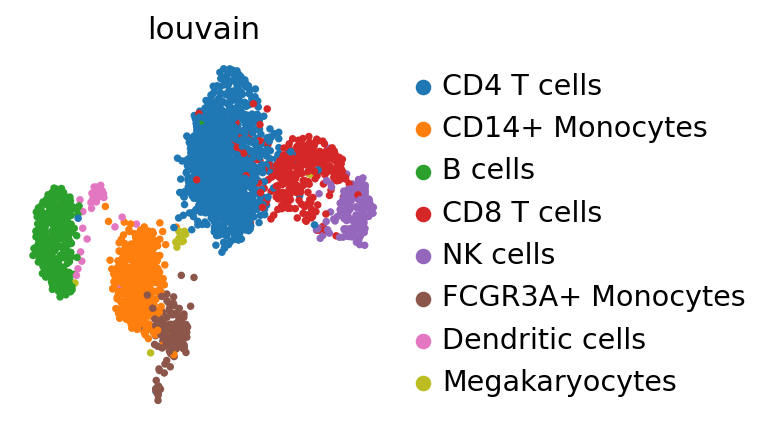

In [7]:
sc.pl.umap(adata_ref, color="louvain")

### Mapping PBMCs using ingest

Let's map labels and embeddings from `adata_ref` to `adata` based on a chosen representation. Here, we use `adata_ref.obsm['X_pca']` to map cluster labels and the UMAP coordinates.

In [8]:
# Safety: ensure reference has PCA computed with metadata required by ingest
# Slicing vars can remove uns['pca']['params'].
if "adata_ref" in globals():
    if "X_pca" not in adata_ref.obsm or "pca" not in adata_ref.uns or "params" not in adata_ref.uns.get("pca", {}):
        sc.pp.pca(adata_ref, n_comps=50, svd_solver="arpack")

In [9]:
sc.tl.ingest(adata, adata_ref, obs="louvain")

/mnt/d/scgeo/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


## ScGeo add-ons: quantify reference vs query geometry

In [10]:
# Normalize naming across tutorial versions:
# Prefer adata_concat if present; else build it.
if "adata_concat" in globals():
    ad = adata_concat
elif "adata" in globals() and "adata_ref" in globals():
    ad = sc.concat({"ref": adata_ref, "new": adata}, label="batch", join="outer", merge="same")
else:
    raise RuntimeError("Expected tutorial variables not found (adata_ref, adata and/or adata_concat).")

condition_key = "batch"
vals = list(ad.obs[condition_key].astype(str).unique())

def _pick(name_list, candidates):
    for c in candidates:
        for x in name_list:
            if x == c:
                return x
    return None

group0 = _pick(vals, ["ref", "reference", "train"]) or sorted(vals)[0]
group1 = _pick(vals, ["new", "qry", "query", "test"]) or sorted(vals)[-1]
print("ScGeo condition_key:", condition_key, "group0:", group0, "group1:", group1)

if "X_umap" not in ad.obsm:
    sc.pp.neighbors(ad)
    sc.tl.umap(ad)

if "X_pca" not in ad.obsm:
    sc.pp.pca(ad, n_comps=50, svd_solver="arpack")

ScGeo condition_key: batch group0: ref group1: new


In [11]:
# 1) Δ shift (global and by louvain if present)
by = "louvain" if "louvain" in ad.obs.columns else None

sg.tl.shift(
    ad,
    rep="X_umap",
    condition_key=condition_key,
    group0=group0,
    group1=group1,
    by=by,
)
print("Shift(global):", ad.uns["scgeo"]["shift"]["global"])

Shift(global): {'n1': 700, 'n0': 2638, 'mu1': array([ 5.0731573, -0.3980835], dtype=float32), 'mu0': array([ 5.9191194 , -0.05806686], dtype=float32), 'delta': array([-0.84596205, -0.34001666], dtype=float32), 'delta_norm': 0.9117363095283508}


In [12]:
# 2) Density overlap on UMAP (Bhattacharyya / Hellinger)
sg.tl.density_overlap(
    ad,
    rep="X_umap",
    condition_key=condition_key,
    group0=group0,
    group1=group1,
    by=by,
    k=30,
)
print("Density overlap(global):", ad.uns["scgeo"]["density_overlap"]["global"])

Density overlap(global): {'n1': 700, 'n0': 2638, 'bc': 0.8681783773567542, 'hellinger': 0.36307247574450724}


In [13]:
# 3) Global distribution test on PCA (energy distance + permutation p-value)
# Demo uses sample_key=batch; in real data use donor/sample.
sample_key = condition_key

sg.tl.distribution_test(
    ad,
    rep="X_pca",
    condition_key=condition_key,
    group0=group0,
    group1=group1,
    sample_key=sample_key,
    method="energy",
    n_perm=200,
    seed=0,
)
print("Distribution test(global):", ad.uns["scgeo"]["distribution_test"]["global"])

Distribution test(global): {'stat': 0.08650016784667969, 'p_perm': 1.0, 'n1': 700, 'n0': 2638, 'n_perm': 200}


In [14]:
# 4) Composition stats per cluster (bootstrap demo-safe; switch to method="gee" with real sample_key)
group_key = "louvain" if "louvain" in ad.obs.columns else None
if group_key is None:
    sc.pp.neighbors(ad)
    sc.tl.leiden(ad, key_added="leiden", resolution=0.8)
    group_key = "leiden"

sg.tl.paga_composition_stats(
    ad,
    group_key=group_key,
    condition_key=condition_key,
    group0=group0,
    group1=group1,
    sample_key=sample_key,
    method="bootstrap",
    n_boot=500,
    seed=0,
)

tbl = ad.uns["scgeo"]["paga_composition_stats"]["table"].sort_values("p")
tbl.head(12)

,node,method,effect,CI_low,CI_high,p,n_boot,q
0,B cells,bootstrap,0.006071,0.006071,0.006071,0.0,500,0.0
1,CD14+ Monocytes,bootstrap,-0.031956,-0.031956,-0.031956,0.0,500,0.0
2,CD4 T cells,bootstrap,-0.017948,-0.017948,-0.017948,0.0,500,0.0
3,CD8 T cells,bootstrap,-0.039788,-0.039788,-0.039788,0.0,500,0.0
4,Dendritic cells,bootstrap,0.007403,0.007403,0.007403,0.0,500,0.0
5,FCGR3A+ Monocytes,bootstrap,0.108853,0.108853,0.108853,0.0,500,0.0
6,Megakaryocytes,bootstrap,-0.005686,-0.005686,-0.005686,0.0,500,0.0
7,NK cells,bootstrap,-0.026949,-0.026949,-0.026949,0.0,500,0.0


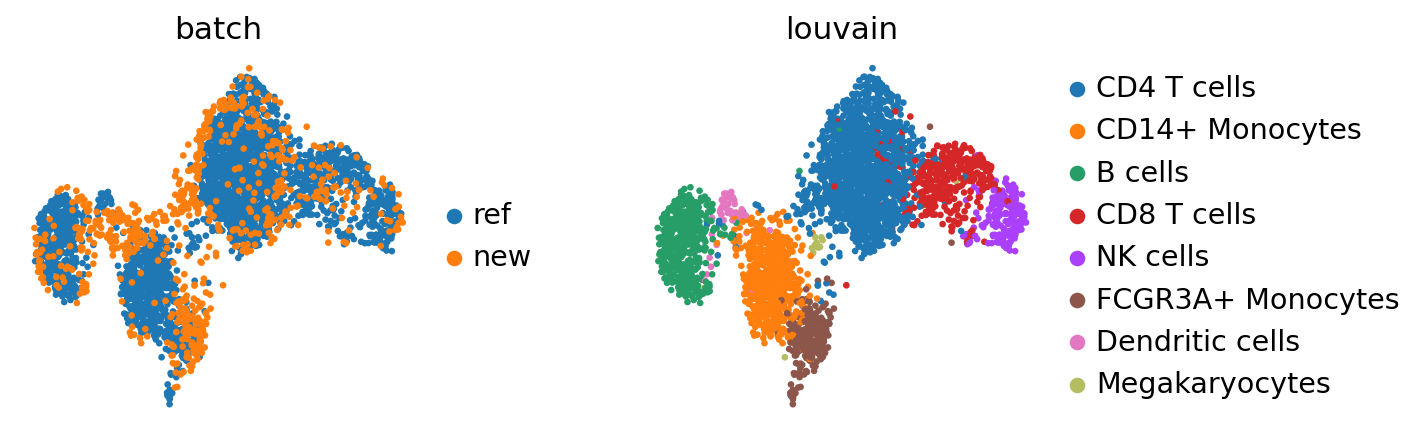

In [15]:
# Helper plots
sc.pl.umap(ad, color=[condition_key, "louvain" if "louvain" in ad.obs.columns else group_key], wspace=0.4)

In [16]:
adata.uns["louvain_colors"] = adata_ref.uns["louvain_colors"]  # fix colors

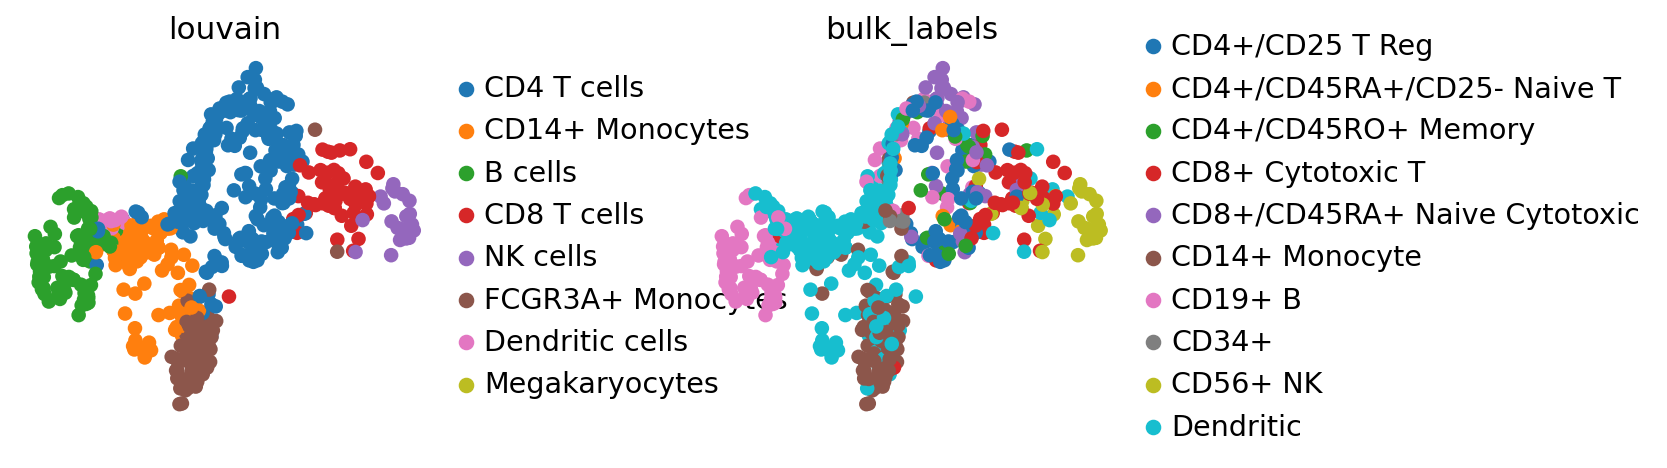

In [17]:
sc.pl.umap(adata, color=["louvain", "bulk_labels"], wspace=0.5)

By comparing the 'bulk_labels' annotation with 'louvain', we see that the data has been reasonably mapped, only the annotation of dendritic cells seems ambiguous and might have been ambiiguous in `adata` already.

In [18]:
adata_concat = anndata.concat([adata_ref, adata], label="batch", keys=["ref", "new"])

In [19]:
adata_concat.obs["louvain"] = (
    adata_concat.obs["louvain"].astype("category").cat.reorder_categories(adata_ref.obs["louvain"].cat.categories)
)
# fix category colors
adata_concat.uns["louvain_colors"] = adata_ref.uns["louvain_colors"]

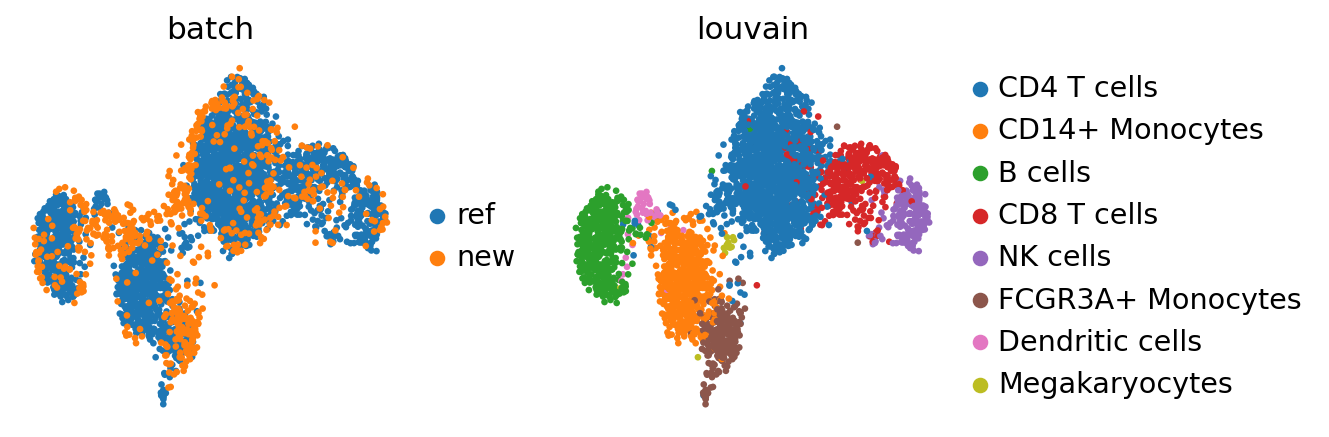

In [20]:
sc.pl.umap(adata_concat, color=["batch", "louvain"])

While there seems to be some batch-effect in the monocytes and dendritic cell clusters, the new data is otherwise mapped relatively homogeneously.

The megakaryoctes are only present in `adata_ref` and no cells from `adata` map onto them. If interchanging reference data and query data, Megakaryocytes do not appear as a separate cluster anymore. This is an extreme case as the reference data is very small; but one should always question if the reference data contain enough biological variation to meaningfully accomodate query data.

### Using BBKNN

In [21]:
sc.tl.pca(adata_concat)

In [22]:
%%time
sc.external.pp.bbknn(adata_concat, batch_key="batch")  # running bbknn 1.3.6

CPU times: user 2.07 s, sys: 9.15 ms, total: 2.07 s
Wall time: 914 ms


In [23]:
sc.tl.umap(adata_concat)

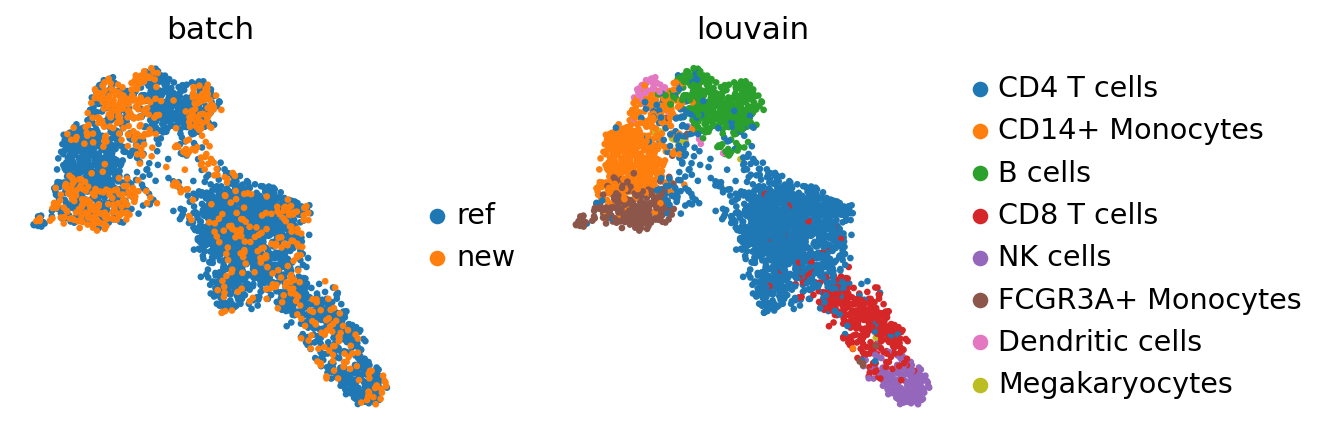

In [24]:
sc.pl.umap(adata_concat, color=["batch", "louvain"])

Also BBKNN doesn't maintain the Megakaryocytes cluster. However, it seems to mix cells more homogeneously.

## Pancreas

The following data has been used in the scGen paper {cite:p}`Lotfollahi2019`, has been used [here][batch-removal],
was curated [here][curation] and can be downloaded from [here (the BBKNN paper)][paper].

It contains data for human pancreas from 4 different studies {cite:p}`Segerstolpe2016,Baron2016,Wang2016,Muraro2016`,
which have been used in the seminal papers on single-cell dataset integration {cite:p}`Butler2018,Haghverdi2018` and many times ever since.

[batch-removal]: https://nbviewer.jupyter.org/github/M0hammadL/scGen_notebooks/blob/master/notebooks/scgen_batch_removal.ipynb
[curation]: https://nbviewer.jupyter.org/github/Teichlab/bbknn/blob/master/examples/pancreas.ipynb
[paper]: ftp://ngs.sanger.ac.uk/production/teichmann/BBKNN/objects-pancreas.zip

In [25]:
# note that this collection of batches is already intersected on the genes
adata_all = sc.read(
    "data/pancreas.h5ad",
    backup_url="https://www.dropbox.com/s/qj1jlm9w10wmt0u/pancreas.h5ad?dl=1",
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 176M/176M [00:14<00:00, 12.9MB/s]
/mnt/d/scgeo/.venv/lib/python3.12/site-packages/anndata/_io/h5ad.py:267: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  return AnnData(**{
/mnt/d/scgeo/.venv/lib/python3.12/site-packages/anndata/_io/h5ad.py:267: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  return AnnData(**{


In [26]:
adata_all.shape

(14693, 2448)

Inspect the cell types observed in these studies.

In [27]:
counts = adata_all.obs["celltype"].value_counts()
counts.to_frame()

,count
celltype,
alpha,4214
beta,3354
ductal,1804
acinar,1368
not applicable,1154
delta,917
gamma,571
endothelial,289
activated_stellate,284


To simplify visualization, let's remove the 5 minority classes.

In [28]:
minority_classes = counts.index[-5:].tolist()  # get the minority classes
# actually subset
adata_all = adata_all[~adata_all.obs["celltype"].isin(minority_classes)].copy()
# reorder according to abundance
adata_all.obs["celltype"] = adata_all.obs["celltype"].cat.reorder_categories(counts.index[:-5].tolist())

### Seeing the batch effect

In [29]:
sc.pp.pca(adata_all)
sc.pp.neighbors(adata_all)
sc.tl.umap(adata_all)

We observe a batch effect.

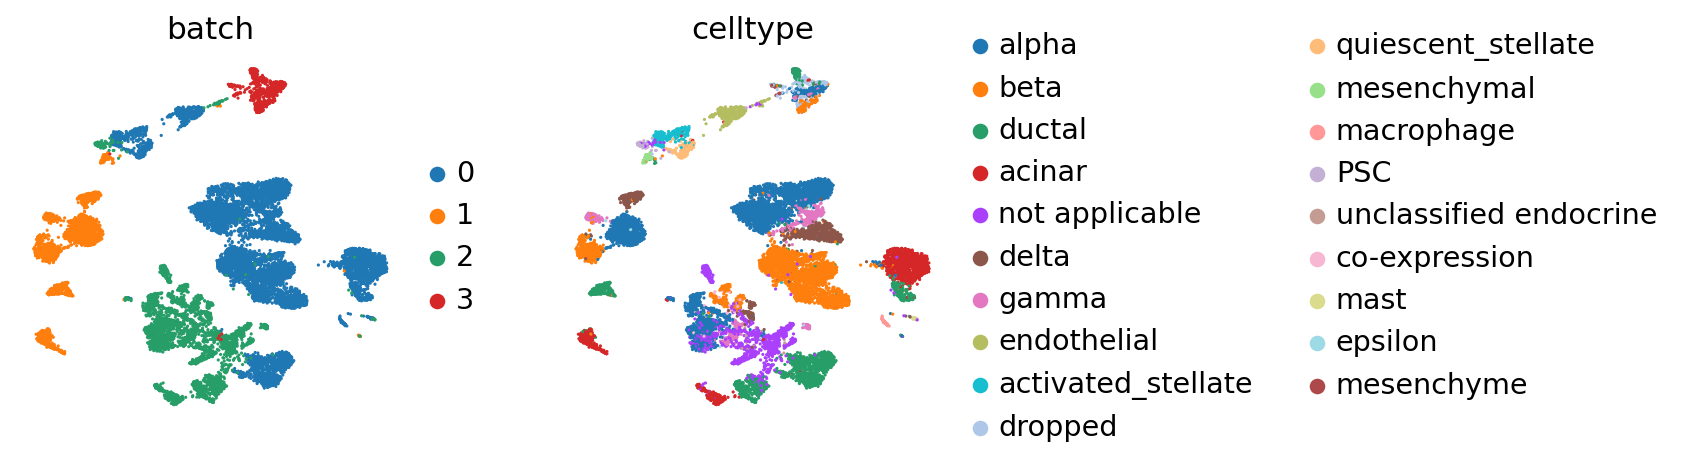

In [30]:
sc.pl.umap(adata_all, color=["batch", "celltype"], palette=sc.pl.palettes.vega_20_scanpy)

### BBKNN

It can be well-resolved using [BBKNN](https://github.com/Teichlab/bbknn) {cite:p}`Polanski2019`.

In [31]:
%%time
sc.external.pp.bbknn(adata_all, batch_key="batch")

CPU times: user 835 ms, sys: 0 ns, total: 835 ms
Wall time: -2.49e+10 ns


In [32]:
sc.tl.umap(adata_all)

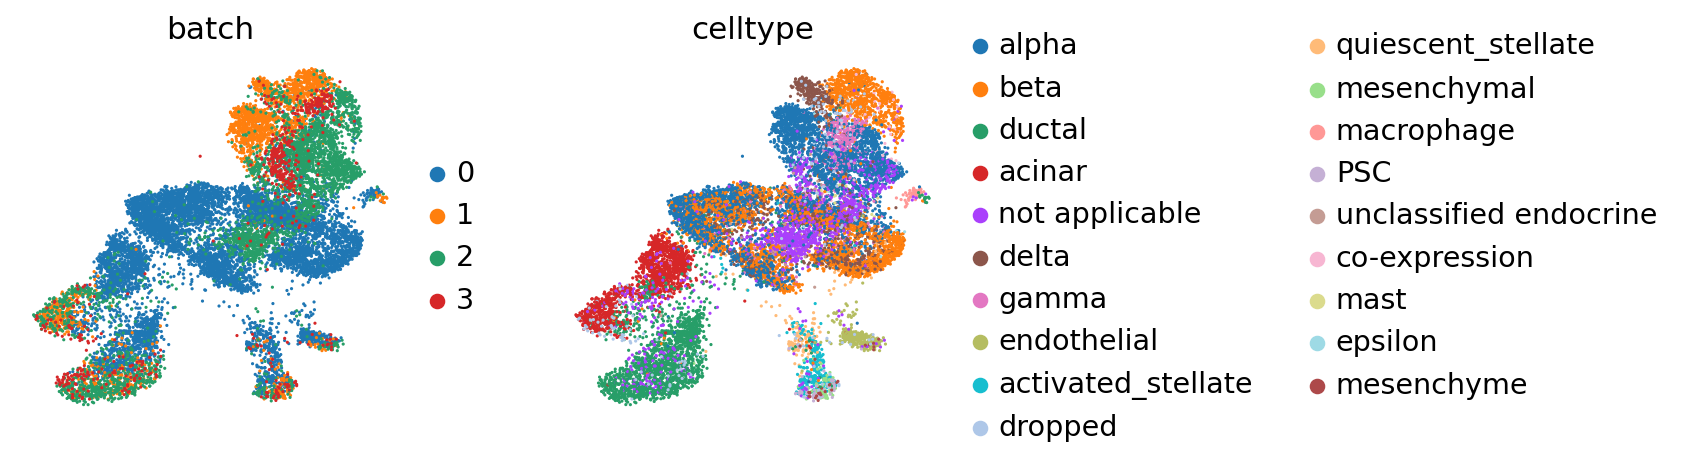

In [33]:
sc.pl.umap(adata_all, color=["batch", "celltype"])

If one prefers to work more iteratively starting from one reference dataset, one can use ingest.

### Mapping onto a reference batch using ingest

Choose one reference batch for training the model and setting up the neighborhood graph (here, a PCA) and separate out all other batches.

As before, the model trained on the reference batch will explain the biological variation observed within it.

In [34]:
adata_ref = adata_all[adata_all.obs["batch"] == "0"].copy()

Compute the PCA, neighbors and UMAP on the reference data.

In [35]:
sc.pp.pca(adata_ref)
sc.pp.neighbors(adata_ref)
sc.tl.umap(adata_ref)

The reference batch contains 12 of the 19 cell types across all batches.

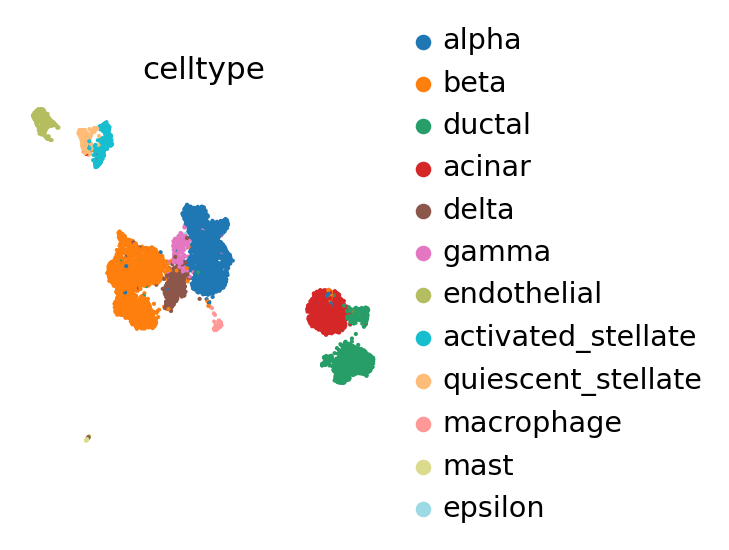

In [36]:
sc.pl.umap(adata_ref, color="celltype")

Iteratively map labels (such as 'celltype') and embeddings (such as 'X_pca' and 'X_umap') from the reference data onto the query batches.

In [37]:
adatas = [adata_all[adata_all.obs["batch"] == i].copy() for i in ["1", "2", "3"]]

In [38]:
sc.settings.verbosity = 2  # a bit more logging
for iadata, adata in enumerate(adatas, 1):
    print(f"... integrating batch {iadata}")
    adata.obs["celltype_orig"] = adata.obs["celltype"]  # save the original cell type
    sc.tl.ingest(adata, adata_ref, obs="celltype")

... integrating batch 1
running ingest


/mnt/d/scgeo/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


    finished (0:00:02)
... integrating batch 2
running ingest


/mnt/d/scgeo/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


    finished (0:00:03)
... integrating batch 3
running ingest


/mnt/d/scgeo/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


    finished (0:00:01)


Each of the query batches now carries annotation that has been contextualized with `adata_ref`. By concatenating, we can view it together.

In [39]:
adata_concat = anndata.concat([adata_ref, *adatas], label="batch", join="outer")

In [40]:
adata_concat.obs["celltype"] = (
    adata_concat.obs["celltype"].astype("category").cat.reorder_categories(adata_ref.obs["celltype"].cat.categories)
)
# fix category coloring
adata_concat.uns["celltype_colors"] = adata_ref.uns["celltype_colors"]

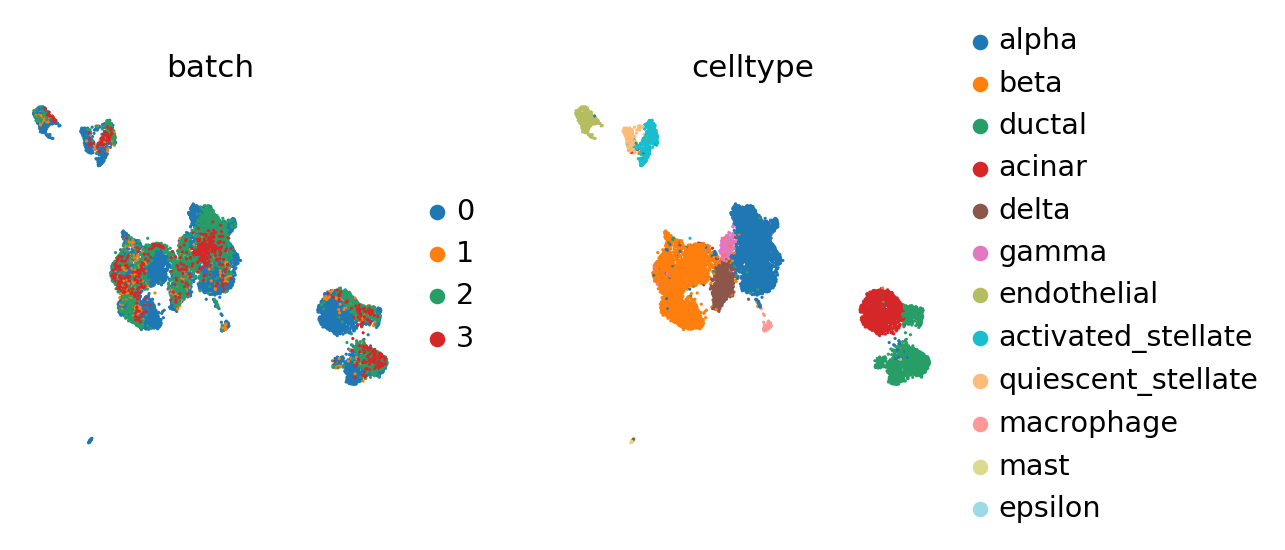

In [41]:
sc.pl.umap(adata_concat, color=["batch", "celltype"])

Compared to the BBKNN result, this is maintained clusters in a much more pronounced fashion. If one already observed a desired continuous structure (as in the hematopoietic datasets, for instance), `ingest` allows to easily maintain this structure.

### Evaluating consistency

Let us subset the data to the query batches.

In [42]:
adata_query = adata_concat[adata_concat.obs["batch"].isin(["1", "2", "3"])].copy()

The following plot is a bit hard to read, hence, move on to confusion matrices below.

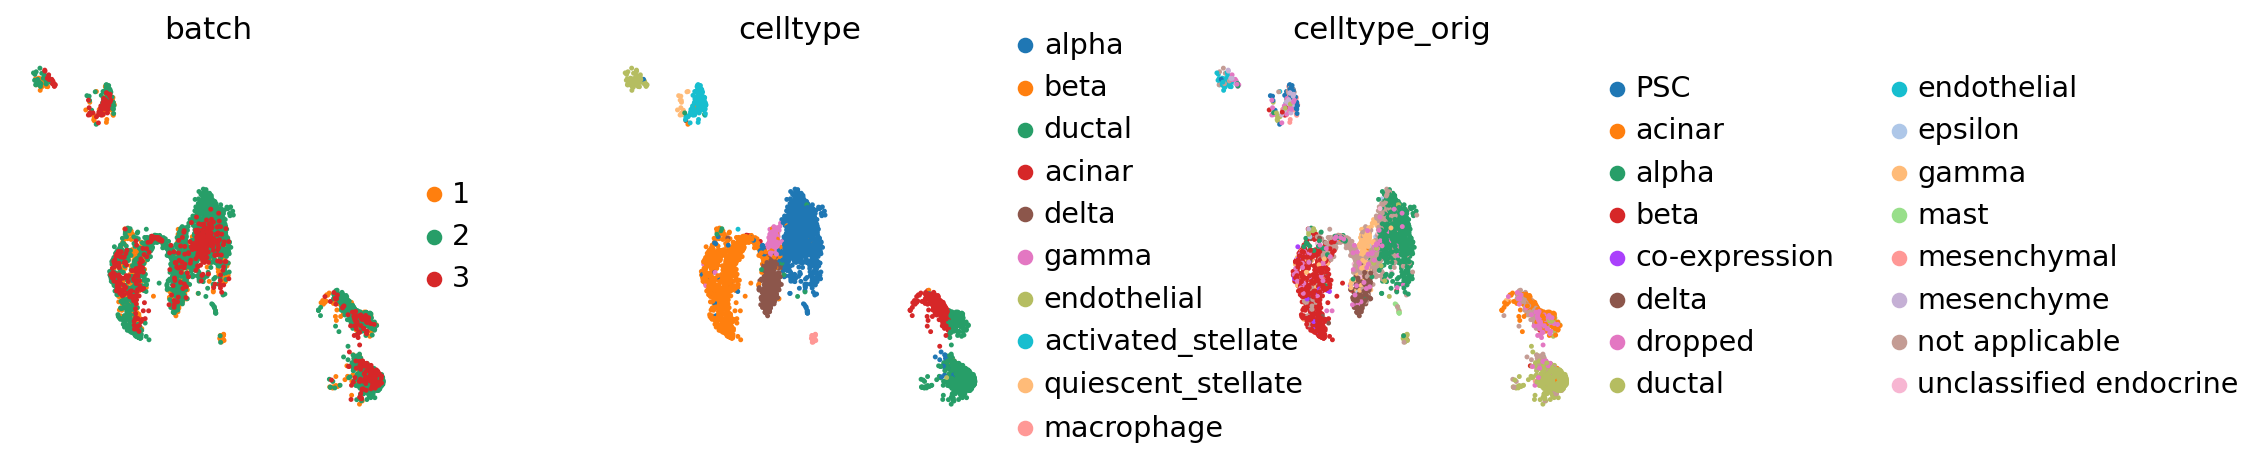

In [43]:
sc.pl.umap(adata_query, color=["batch", "celltype", "celltype_orig"], wspace=0.4)

#### Cell types conserved across batches

Let us first focus on cell types that are conserved with the reference, to simplify reading of the confusion matrix.

In [44]:
# intersected categories
conserved_categories = adata_query.obs["celltype"].cat.categories.intersection(
    adata_query.obs["celltype_orig"].cat.categories
)
# intersect categories
obs_query_conserved = adata_query.obs.loc[
    adata_query.obs["celltype"].isin(conserved_categories) & adata_query.obs["celltype_orig"].isin(conserved_categories)
].copy()
# remove unused categories
obs_query_conserved["celltype"] = obs_query_conserved["celltype"].cat.remove_unused_categories()
# remove unused categories and fix category ordering
obs_query_conserved["celltype_orig"] = (
    obs_query_conserved["celltype_orig"]
    .cat.remove_unused_categories()
    .cat.reorder_categories(obs_query_conserved["celltype"].cat.categories)
)

In [45]:
pd.crosstab(obs_query_conserved["celltype"], obs_query_conserved["celltype_orig"])

celltype_orig,alpha,beta,ductal,acinar,delta,gamma,endothelial
celltype,,,,,,,
alpha,1815,3,13,0,1,20,0
beta,52,805,6,1,11,39,0
ductal,7,6,685,241,0,0,0
acinar,2,3,3,166,0,3,0
delta,6,3,1,0,304,72,0
gamma,1,5,0,1,0,182,0
endothelial,2,0,0,0,0,0,36


Overall, the conserved cell types are also mapped as expected. The main exception are some acinar cells in the original annotation that appear as acinar cells. However, already the reference data is observed to feature a cluster of both acinar and ductal cells, which explains the discrepancy, and indicates a potential inconsistency in the initial annotation.

#### All cell types

Let us now move on to look at all cell types.

In [46]:
pd.crosstab(adata_query.obs["celltype"], adata_query.obs["celltype_orig"])

celltype_orig,PSC,acinar,alpha,beta,co-expression,delta,dropped,ductal,endothelial,epsilon,gamma,mast,mesenchymal,mesenchyme,not applicable,unclassified endocrine
celltype,,,,,,,,,,,,,,,,
alpha,0,0,1815,3,3,1,35,13,0,4,20,7,0,0,305,8
beta,1,1,52,805,36,11,40,6,0,0,39,0,0,1,521,25
ductal,0,241,7,6,0,0,42,685,0,0,0,0,2,0,99,1
acinar,0,166,2,3,0,0,23,3,0,0,3,0,0,0,90,0
delta,0,0,6,3,0,304,13,1,0,5,72,0,0,0,98,7
gamma,0,1,1,5,0,0,2,0,0,1,182,0,0,0,15,0
endothelial,1,0,2,0,0,0,7,0,36,0,0,0,0,6,7,0
activated_stellate,48,1,1,2,0,0,11,6,0,0,0,0,78,20,17,0
quiescent_stellate,4,0,1,1,0,0,5,1,1,0,0,0,0,0,1,0


We observe that PSC ([pancreatic stellate cells](https://en.wikipedia.org/wiki/Pancreatic_stellate_cell)) cells are in fact just inconsistently annotated and correctly mapped on 'activated_stellate' cells.

Also, it's nice to see that 'mesenchyme' and 'mesenchymal' cells both map onto the same category. However, that category is again 'activated_stellate' and likely incorrect.

### Visualizing distributions across batches

Often, batches correspond to experiments that one wants to compare. Scanpy offers to convenient visualization possibilities for this.

1. a density plot
2. a partial visualization of a subset of categories/groups in an emnbedding

#### Density plot

In [47]:
sc.tl.embedding_density(adata_concat, groupby="batch")

computing density on 'umap'


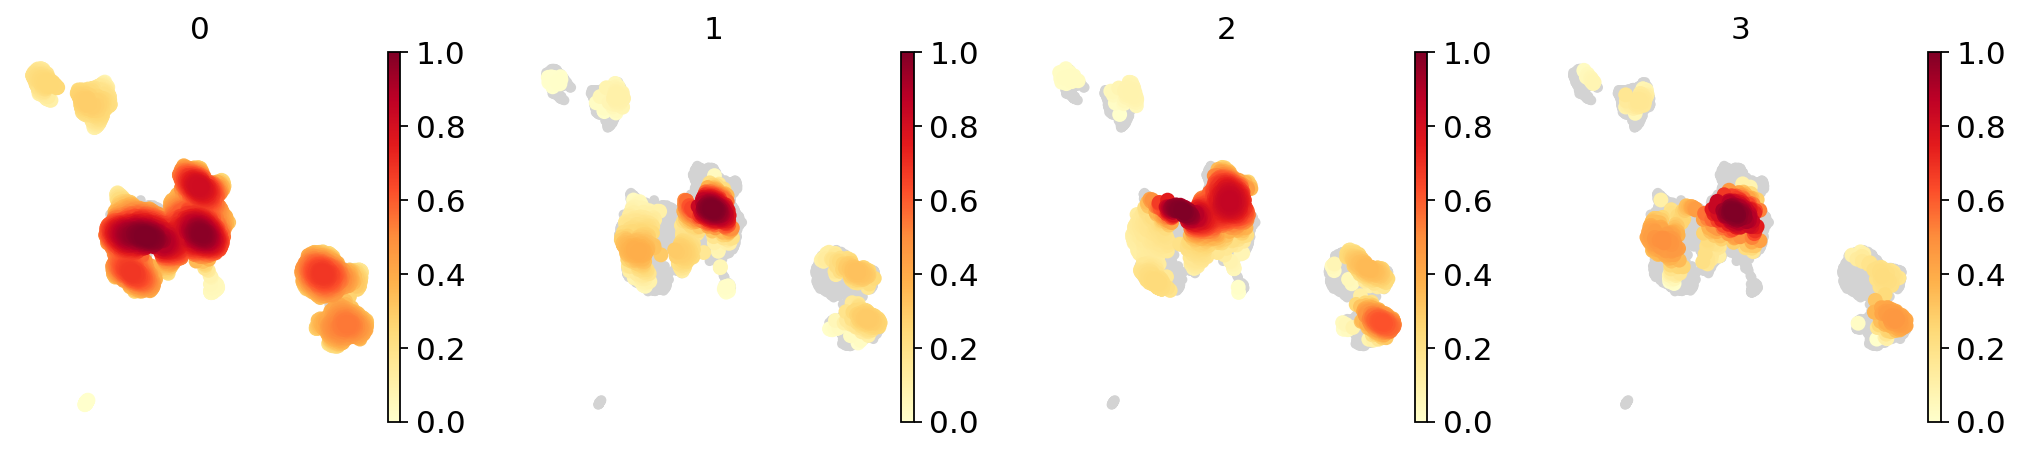

In [48]:
sc.pl.embedding_density(adata_concat, groupby="batch")

#### Partial visualizaton of a subset of groups in embedding

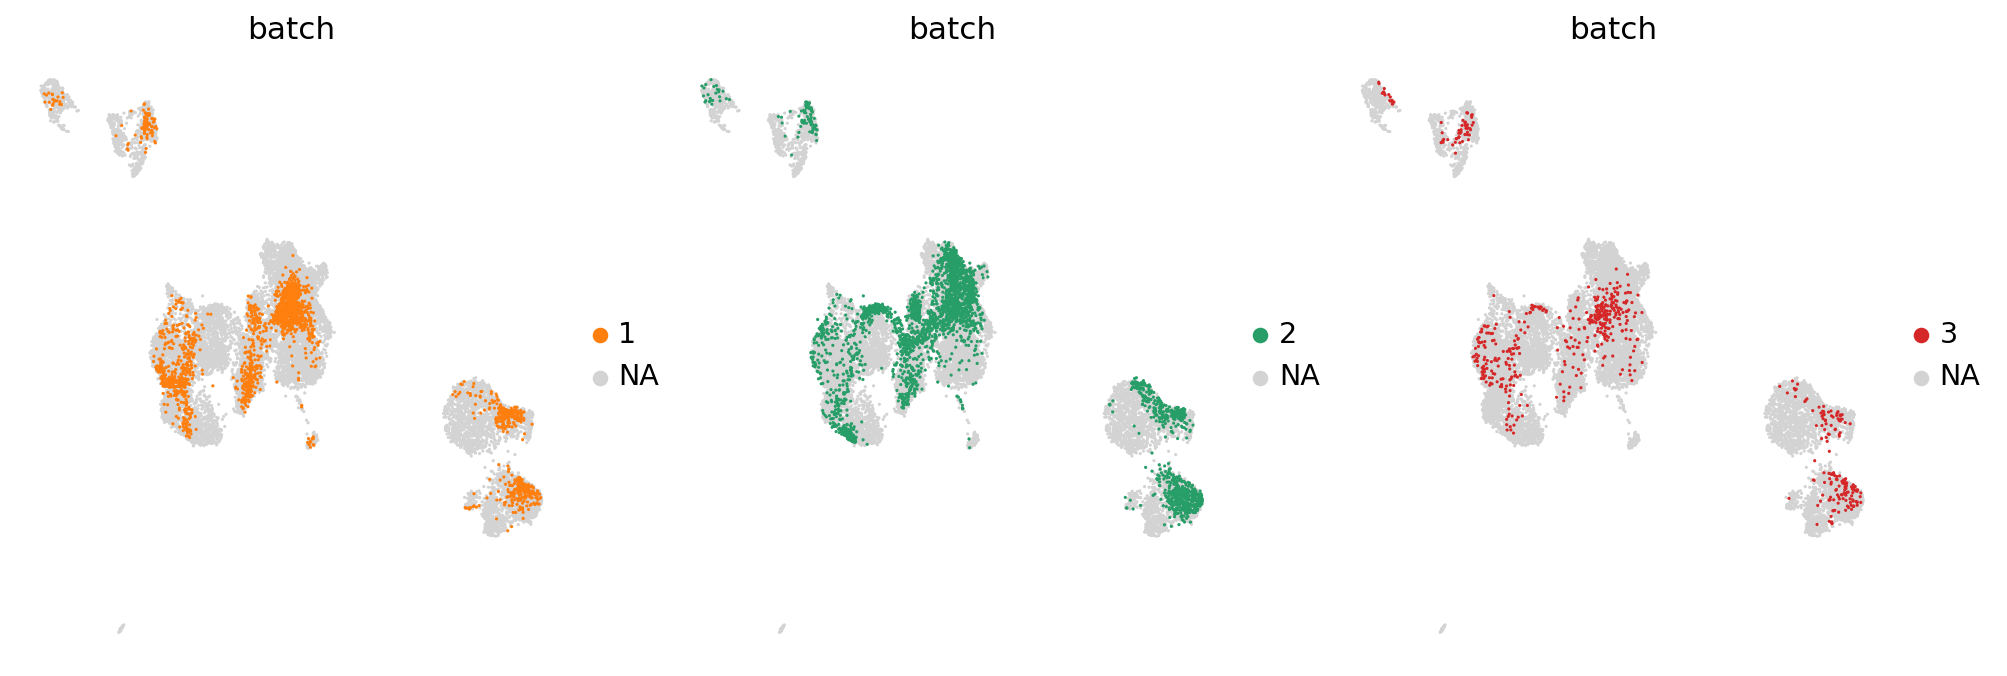

In [49]:
import matplotlib.pyplot as plt


fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for batch, ax in zip(["1", "2", "3"], axes, strict=True):
    sc.pl.umap(adata_concat, color="batch", groups=[batch], ax=ax, show=False)